In [1]:
import os
from pathlib import Path
import pickle

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images


In [2]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)

In [3]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7
#     volume_feature_blocks = 1


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 12
    popular_days = 7
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7
    volume_feature_blocks = 2

In [5]:
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks+1}.pkl")
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks}.pkl")

In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        # TODO: 元々バグってたので閾値とか要検討
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("cnt > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week)

    candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 1
volume: 1095670
duplicates: 1.0026290335716515
            strategy  volume     ratio
0  same_product_code  663879  0.605911
1         repurchase  346369  0.316125
2                pop   83772  0.076457
3               cooc    1650  0.001506
week: 2
volume: 1157773
duplicates: 1.0032121213171517
            strategy  volume     ratio
0  same_product_code  699175  0.603896
1         repurchase  369722  0.319339
2                pop   86724  0.074906
3               cooc    2152  0.001859
week: 3
volume: 1205488
duplicates: 1.0031722361102327
            strategy  volume     ratio
0  same_product_code  733873  0.608777
1         repurchase  378613  0.314074
2                pop   90708  0.075246
3               cooc    2294  0.001903
week: 4
volume: 1292783
duplicates: 1.003050001086238
            strategy  volume     ratio
0  same_product_code  801226  0.619768
1         repurchase  391545  0.302870
2                pop   97596  0.075493
3               cooc    2416  0.001869


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


week: 0
Recall: 0.0959882087421123
            strategy      y  volume    recall  hit_ratio
0         repurchase  860.0  346369  0.039611   0.002483
1  same_product_code  786.0  663879  0.036203   0.001184
2                pop  475.0   83772  0.021878   0.005670
3               cooc   16.0    1650  0.000737   0.009697
week: 1
Recall: 0.09287543038756953
            strategy      y  volume    recall  hit_ratio
0         repurchase  915.0  369722  0.040390   0.002475
1  same_product_code  808.0  699175  0.035667   0.001156
2                pop  448.0   86724  0.019776   0.005166
3               cooc   16.0    2152  0.000706   0.007435
week: 2
Recall: 0.09402291995058151
            strategy      y  volume    recall  hit_ratio
0         repurchase  922.0  378613  0.039279   0.002435
1  same_product_code  854.0  733873  0.036382   0.001164
2                pop  483.0   90708  0.020577   0.005325
3               cooc   19.0    2294  0.000809   0.008282
week: 3
Recall: 0.08824915560443013
  

In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 1095670 -> 292616
drop trivial queries: 1157773 -> 303626
drop trivial queries: 1205488 -> 318997
drop trivial queries: 1292783 -> 318390


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['age']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name=f'item_volume_{i}')
        df = df.merge(tmp, on='item', how='left')

    # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
    # tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
    # df = df.merge(tmp, on='user', how='left')

    # user volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name=f'user_volume_{i}')
        df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    # lfm features
    lfm_path = ARTIFACTS_DIR / f"lfm_{dataset}_{pretrain_week}.pkl"

    with open(lfm_path, 'rb') as f:
        lfm = pickle.load(f)
    no_components = lfm.get_params()['no_components']

    # df['lfm'] = lfm.predict(df['user'].values, df['item'].values, num_threads=psutil.cpu_count(logical=False))

    user_reps = np.hstack([lfm.user_embeddings, lfm.user_biases.reshape((len(users), 1))])
    user_reps = pd.DataFrame(user_reps, columns=[f'user_rep_{i}' for i in range(no_components+1)])
    user_reps = pd.concat([pd.DataFrame({'user': range(len(users))}), user_reps], axis=1)
    df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

week: 1
week: 1
week: 2
week: 3
week: 4


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'age', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume_0', 'item_volume_1', 'user_volume_0', 'user_volume_1', 'user_item_day_min', 'user_item_volume_x', 'user_item_volume_y', 'user_rep_0', 'user_rep_1', 'user_rep_2', 'user_rep_3', 'user_rep_4', 'user_rep_5', 'user_rep_6', 'user_rep

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

In [17]:
ITERATIONS = 5000

ORDINAL

In [18]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 300,
    'iterations': ITERATIONS,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.1889212	best: 0.1889212 (0)	total: 231ms	remaining: 19m 13s
1:	test: 0.2462630	best: 0.2462630 (1)	total: 374ms	remaining: 15m 35s
2:	test: 0.2489530	best: 0.2489530 (2)	total: 528ms	remaining: 14m 40s
3:	test: 0.2498605	best: 0.2498605 (3)	total: 670ms	remaining: 13m 57s
4:	test: 0.2498596	best: 0.2498605 (3)	total: 812ms	remaining: 13m 30s
5:	test: 0.2529422	best: 0.2529422 (5)	total: 953ms	remaining: 13m 13s
6:	test: 0.2669053	best: 0.2669053 (6)	total: 1.1s	remaining: 13m 1s
7:	test: 0.2668130	best: 0.2669053 (6)	total: 1.24s	remaining: 12m 51s
8:	test: 0.2840368	best: 0.2840368 (8)	total: 1.38s	remaining: 12m 47s
9:	test: 0.2842442	best: 0.2842442 (9)	total: 1.53s	remaining: 12m 42s
10:	test: 0.2987867	best: 0.2987867 (10)	total: 1.67s	remaining: 12m 37s
11:	test: 0.3277995	best: 0.3277995 (11)	total: 1.81s	remaining: 12m 34s
12:	test: 0.3292851	best: 0.3292851 (12)	total: 1.97s	remaining: 12m 34s
13:	test: 0.3403411	best: 0.3403411 (13)	total: 2.11s	remaining: 12m 31s


In [19]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.0311221058630609


ORDINAL (ohe: 0)

In [20]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 0,
    'iterations': ITERATIONS,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.1761247	best: 0.1761247 (0)	total: 402ms	remaining: 33m 29s
1:	test: 0.1771030	best: 0.1771030 (1)	total: 824ms	remaining: 34m 18s
2:	test: 0.1928872	best: 0.1928872 (2)	total: 1.21s	remaining: 33m 28s
3:	test: 0.2472010	best: 0.2472010 (3)	total: 1.59s	remaining: 33m 4s
4:	test: 0.2601006	best: 0.2601006 (4)	total: 1.96s	remaining: 32m 38s
5:	test: 0.2602585	best: 0.2602585 (5)	total: 2.34s	remaining: 32m 24s
6:	test: 0.2604685	best: 0.2604685 (6)	total: 2.71s	remaining: 32m 12s
7:	test: 0.2710430	best: 0.2710430 (7)	total: 3.08s	remaining: 32m 1s
8:	test: 0.2975167	best: 0.2975167 (8)	total: 3.47s	remaining: 32m 5s
9:	test: 0.3244130	best: 0.3244130 (9)	total: 3.85s	remaining: 32m
10:	test: 0.3248958	best: 0.3248958 (10)	total: 4.23s	remaining: 31m 57s
11:	test: 0.3362237	best: 0.3362237 (11)	total: 4.59s	remaining: 31m 50s
12:	test: 0.3369423	best: 0.3369423 (12)	total: 4.98s	remaining: 31m 49s
13:	test: 0.3377448	best: 0.3377448 (13)	total: 5.34s	remaining: 31m 43s
14:	t

<BarContainer object of 58 artists>

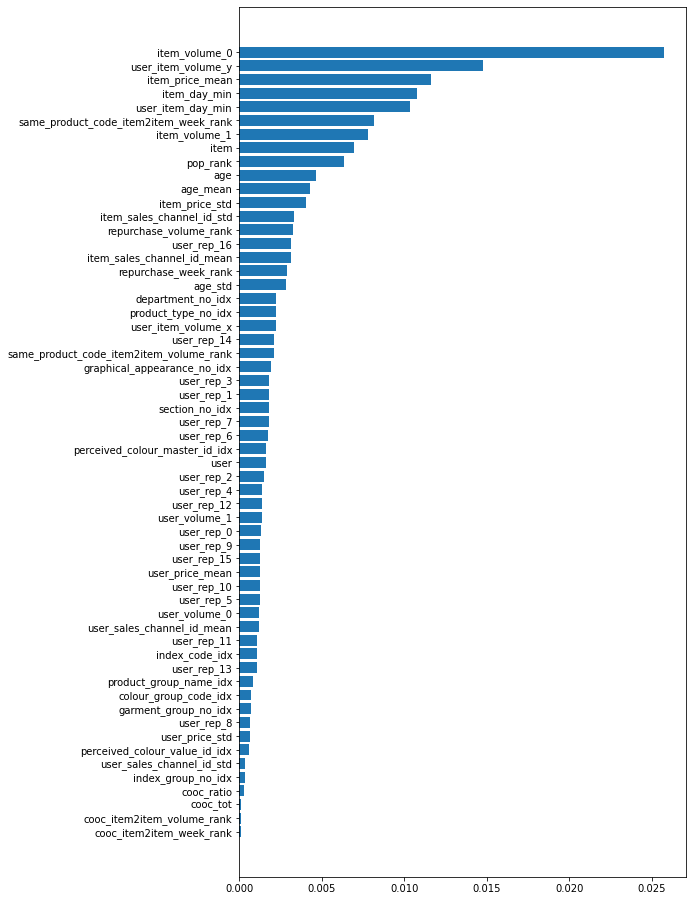

In [21]:
feature_importance = model.get_feature_importance(train_pool)
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 16))
plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [22]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03138146095723163


YetiRankPairwise

In [23]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

params = {
    'loss_function': 'YetiRankPairwise',
    'use_best_model': True,
    'one_hot_max_size': 0,
    'iterations': ITERATIONS,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.1753674	best: 0.1753674 (0)	total: 468ms	remaining: 38m 58s
1:	test: 0.2439494	best: 0.2439494 (1)	total: 950ms	remaining: 39m 34s
2:	test: 0.2720822	best: 0.2720822 (2)	total: 1.42s	remaining: 39m 25s
3:	test: 0.2842940	best: 0.2842940 (3)	total: 1.89s	remaining: 39m 16s
4:	test: 0.3041735	best: 0.3041735 (4)	total: 2.36s	remaining: 39m 21s
5:	test: 0.3038385	best: 0.3041735 (4)	total: 2.85s	remaining: 39m 36s
6:	test: 0.3036069	best: 0.3041735 (4)	total: 3.33s	remaining: 39m 35s
7:	test: 0.3284545	best: 0.3284545 (7)	total: 3.82s	remaining: 39m 45s
8:	test: 0.3295655	best: 0.3295655 (8)	total: 4.28s	remaining: 39m 35s
9:	test: 0.3403282	best: 0.3403282 (9)	total: 4.76s	remaining: 39m 35s
10:	test: 0.3410926	best: 0.3410926 (10)	total: 5.23s	remaining: 39m 33s
11:	test: 0.3395746	best: 0.3410926 (10)	total: 5.68s	remaining: 39m 21s
12:	test: 0.3388163	best: 0.3410926 (10)	total: 6.15s	remaining: 39m 21s
13:	test: 0.3387818	best: 0.3410926 (10)	total: 6.61s	remaining: 39m 15

<BarContainer object of 58 artists>

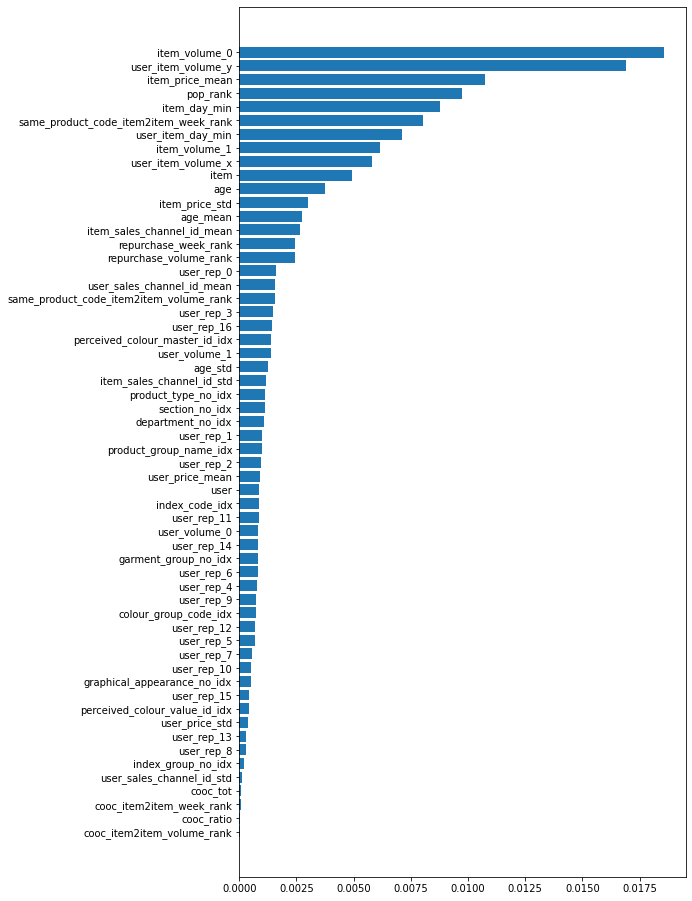

In [24]:
feature_importance = model.get_feature_importance(train_pool)
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 16))
plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [25]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.0312152740794556
